**Check that TensorFlow and NumPy are loaded and display their versions to verify the environment.**

In [47]:
import tensorflow as tf, numpy as np, random
print("TF:", tf.__version__, "| NumPy:", np.__version__)


TF: 2.19.0 | NumPy: 2.0.2


**Upload the ZIP from your computer, unzip it to /content, detect the folder with 'churros', 'donas/donuts', and 'waffles', rename it to /content/postres, and check the structure and image count per class.**


In [5]:
# 1) Sube tu ZIP desde tu computadora (se abre un selector de archivos)
from google.colab import files
up = files.upload()  # selecciona tu "postres.zip" (o similar)

import os, glob, zipfile, shutil, pathlib

# 2) Detecta el ZIP que subiste
zip_files = [n for n in up.keys() if n.lower().endswith(".zip")]
assert zip_files, "No subiste ningún .zip"
zip_name = zip_files[0]
print("ZIP recibido:", zip_name)

# 3) Descomprime en /content
extract_dir = "/content"
with zipfile.ZipFile(zip_name, "r") as zf:
    zf.extractall(extract_dir)

# 4) Busca la carpeta extraída que contenga tus clases y renómbrala a /content/postres
candidates = [p for p in glob.glob("/content/*") if os.path.isdir(p)]
ROOT = None
for cand in candidates:
    subs = [d.lower() for d in os.listdir(cand) if os.path.isdir(os.path.join(cand, d))]
    if any(s in subs for s in ["churros","donas","donuts"]) and "waffles" in subs:
        ROOT = cand
        break

if ROOT is None:
    raise RuntimeError("No encontré una carpeta con subcarpetas 'churros', 'donas/donuts' y 'waffles'. Revisa el ZIP.")

# Si no se llama exactamente /content/postres, renómbrala
if ROOT != "/content/postres":
    if os.path.isdir("/content/postres"):
        shutil.rmtree("/content/postres")
    shutil.move(ROOT, "/content/postres")
ROOT = "/content/postres"

# 5) Verifica estructura y conteo de imágenes
print("ROOT =", ROOT)
!find "/content/postres" -maxdepth 2 -type d | sort

import glob
EXTS = {".jpg",".jpeg",".png",".webp",".jfif"}
for cls in ["churros","donas","donuts","waffles"]:
    p = os.path.join(ROOT, cls)
    if os.path.isdir(p):
        imgs = [q for q in glob.glob(os.path.join(p, "**", "*"), recursive=True)
                if os.path.isfile(q) and pathlib.Path(q).suffix.lower() in EXTS]
        print(f"{cls}: {len(imgs)} imágenes")


Saving postres 1.zip to postres 1.zip
ZIP recibido: postres 1.zip
ROOT = /content/postres
/content/postres
/content/postres/churros
/content/postres/donuts
/content/postres/waffles
churros: 1000 imágenes
donuts: 1000 imágenes
waffles: 1000 imágenes


In [6]:
ROOT = "/content/postres"

**Adjust the dataset path, list the subfolders in ROOT, and count how many images (.jpg/.jpeg/.png) there are per class (churros, donuts, waffles) to verify that the structure is correct.**

In [7]:
# PASO 1 — AJUSTA ESTA RUTA:
ROOT = "/content/postres"  # ej. "/content/drive/MyDrive/postres" si está en Drive

import os, glob
print("ROOT =", ROOT)

print("\nSubcarpetas encontradas:")
for d in sorted([p for p in glob.glob(os.path.join(ROOT, "*")) if os.path.isdir(p)]):
    print(" -", os.path.basename(d))

# Conteo de imágenes por clase (jpg/jpeg/png)
exts = (".jpg",".jpeg",".png")
for cls in ["churros","donuts","waffles"]:
    files = [p for p in glob.glob(os.path.join(ROOT, cls, "*")) if p.lower().endswith(exts)]
    print(f"{cls}: {len(files)} imágenes")



ROOT = /content/postres

Subcarpetas encontradas:
 - churros
 - donuts
 - waffles
churros: 1000 imágenes
donuts: 1000 imágenes
waffles: 1000 imágenes


# **Crea los splits (70% train / 15% val / 15% test)**

**It creates a stratified partition of the dataset by class, shuffling the images with a fixed seed for reproducibility and separating them into 70% for train (what the model uses to learn), 15% for val (what is used to tune hyperparameters and apply early stopping without touching the test) and 15% for test (final evaluation without data leakage); then copies or moves each file to the destination structure /content/postres_split/{train,val,test}/{class}/ and checks the counts per split and per class to maintain the balance and avoid empty classes.**

In [8]:
import os, glob, math, random, shutil, json, pathlib

In [9]:
assert 'ROOT' in globals(), "/content/postres"

CLASSES = ["churros", "donuts", "waffles"]
DST = "/content/postres_split"
SPLITS = {"train":0.70, "val":0.15, "test":0.15}
EXTS = {".jpg",".jpeg",".png",".jfif",".webp"}  # admite varias extensiones
random.seed(42)


In [10]:
# Limpia destino si ya existía (para no duplicar)
if os.path.exists(DST):
    shutil.rmtree(DST)
for s in SPLITS:
    for c in CLASSES:
        os.makedirs(f"{DST}/{s}/{c}", exist_ok=True)


In [11]:
# Recolecta, baraja y distribuye por clase
def gather_images(cls_dir):
    files = []
    for p in glob.glob(os.path.join(cls_dir, "**", "*"), recursive=True):
        if os.path.isfile(p) and pathlib.Path(p).suffix.lower() in EXTS:
            files.append(p)
    return files

summary = {}
for c in CLASSES:
    src_dir = os.path.join(ROOT, c)
    imgs = gather_images(src_dir)
    random.shuffle(imgs)
    n = len(imgs)
    n_tr = math.floor(SPLITS["train"]*n)
    n_va = math.floor(SPLITS["val"]*n)
    parts = {
        "train": imgs[:n_tr],
        "val":   imgs[n_tr:n_tr+n_va],
        "test":  imgs[n_tr+n_va:],
    }
    for split, lst in parts.items():
        for src in lst:
            dst = f"{DST}/{split}/{c}/{os.path.basename(src)}"
            shutil.copy(src, dst)
    summary[c] = {k: len(v) for k, v in parts.items()}

In [12]:
# Guarda las clases para la app web
os.makedirs("models", exist_ok=True)
with open("models/class_names.json","w") as f:
    json.dump(CLASSES, f)

print("Resumen por clase (archivos copiados):")
for c in CLASSES:
    print(f"  {c:8s} -> train: {summary[c]['train']:4d} | val: {summary[c]['val']:4d} | test: {summary[c]['test']:4d}")

print("\nRuta destino:", DST)

Resumen por clase (archivos copiados):
  churros  -> train:  700 | val:  150 | test:  150
  donuts   -> train:  700 | val:  150 | test:  150
  waffles  -> train:  700 | val:  150 | test:  150

Ruta destino: /content/postres_split


# **Data loaders + augmentación**

**The data pipeline that the model will consume is built: data loaders are created from the /train, /val, and /test folders with image_dataset_from_directory , setting the image size (e.g., 224x224), batch_size, and label type (one-hot for your three classes). Next, a normalization/rescaling is chained, and, only for train, real-time augmentation techniques are applied (horizontal flip, rotation, zoom, and, if desired, translation/contrast) so that the model sees different versions of the images and generalizes better; val and test are passed without augmentation to measure real performance. Finally, the datasets are prefetched and optionally cached to speed up training, the order of class_names is confirmed (e.g., ["churros","donuts","waffles"]) and saved if necessary; The result is batches of tensors (X, y) ready for training, with X already the correct size and y categorically encoded.**

In [13]:
import tensorflow as tf, numpy as np
print("TF:", tf.__version__, "| NumPy:", np.__version__)


TF: 2.19.0 | NumPy: 2.0.2


In [14]:
# PASO 3 — Cargar train/val/test desde carpetas y aplicar augmentación
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [15]:
# Cargadores desde las carpetas creadas en el PASO 2
IMG, BATCH = 224, 32
image_ds = tf.keras.utils.image_dataset_from_directory

train_ds = image_ds(
    "/content/postres_split/train",
    image_size=(IMG, IMG),
    batch_size=BATCH,
    label_mode="categorical",
    shuffle=True,
)

val_ds = image_ds(
    "/content/postres_split/val",
    image_size=(IMG, IMG),
    batch_size=BATCH,
    label_mode="categorical",
    shuffle=False,
)

test_ds = image_ds(
    "/content/postres_split/test",
    image_size=(IMG, IMG),
    batch_size=BATCH,
    label_mode="categorical",
    shuffle=False,
)

Found 2100 files belonging to 3 classes.
Found 450 files belonging to 3 classes.
Found 450 files belonging to 3 classes.


It's a quick environment check: it prints the Python version, then attempts to import NumPy and displays its version (if it fails, it reports an error). Then it attempts to import TensorFlow, prints its version, and if a GPU is visible, it verifies that tf.keras is usable, builds a micromodel (Conv2D → GAP), compiles it, and does a 1-epoch mini-train run on random data; if everything runs fine, it prints "Mini-train OK ✅". If anything fails in any of those steps, it captures and displays the corresponding error. (Note: platform and importlib are imported but not used.)

In [16]:
import sys, platform, importlib

print("Python:", sys.version)
try:
    import numpy as np
    print("NumPy:", np.__version__)
except Exception as e:
    print("NumPy import ERROR:", repr(e))

try:
    import tensorflow as tf
    print("TensorFlow:", tf.__version__)
    print("GPU visible:", tf.config.list_physical_devices('GPU'))
    # intenta cargar tf.keras
    from tensorflow import keras
    print("tf.keras OK")
    # prueba micro-modelo
    i = keras.Input((32,32,3))
    x = keras.layers.Conv2D(4,3,activation="relu")(i)
    o = keras.layers.GlobalAveragePooling2D()(x)
    m = keras.Model(i,o)
    m.compile(optimizer="adam", loss="mse")
    import numpy as np
    x = np.random.rand(2,32,32,3).astype("float32")
    y = np.random.rand(2,4).astype("float32")
    m.fit(x,y,epochs=1,verbose=0)
    print("Mini-train OK ✅")
except Exception as e:
    print("TensorFlow / tf.keras ERROR:", repr(e))


Python: 3.11.13 (main, Jun  4 2025, 08:57:29) [GCC 11.4.0]
NumPy: 2.0.2
TensorFlow: 2.19.0
GPU visible: []
tf.keras OK
Mini-train OK ✅


In [17]:
# PASO 3 — Loaders + augmentación (TF 2.19, corregido)

import os, json
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Ruta donde se creo los splits en el PASO 2 (debe contener train/, val/, test/)
BASE = "/content/postres_split"
assert os.path.isdir(BASE), f"No existe {BASE}. Repite el paso de splits."

# Parámetros
IMG, BATCH = 224, 32
image_ds = tf.keras.utils.image_dataset_from_directory

# 1) Cargar datasets crudos
train_raw = image_ds(f"{BASE}/train", image_size=(IMG, IMG), batch_size=BATCH,
                     label_mode="categorical", shuffle=True)
val_raw   = image_ds(f"{BASE}/val",   image_size=(IMG, IMG), batch_size=BATCH,
                     label_mode="categorical", shuffle=False)
test_raw  = image_ds(f"{BASE}/test",  image_size=(IMG, IMG), batch_size=BATCH,
                     label_mode="categorical", shuffle=False)

# 2) Clases ANTES de map/prefetch
class_names = list(train_raw.class_names)  # p.ej. ['churros','donuts','waffles']
num_classes = len(class_names)
print("Clases detectadas:", class_names, "| num_classes:", num_classes)

# Guarda nombres de clase para la app web
os.makedirs("models", exist_ok=True)
with open("models/class_names.json", "w") as f:
    json.dump(class_names, f)

# 3) Augmentación
data_aug = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
], name="data_aug")

# 4) Map + Prefetch (nota: en Keras 3/TF 2.19 usa training=True como keyword)
AUTO = tf.data.AUTOTUNE
train_ds = train_raw.map(lambda x, y: (data_aug(x, training=True), y),
                         num_parallel_calls=AUTO).prefetch(AUTO)
val_ds   = val_raw.prefetch(AUTO)
test_ds  = test_raw.prefetch(AUTO)

# 5) Comprobación rápida de shapes
xb, yb = next(iter(train_raw))
print("Batch X:", xb.shape, "| Batch y:", yb.shape)


Found 2100 files belonging to 3 classes.
Found 450 files belonging to 3 classes.
Found 450 files belonging to 3 classes.
Clases detectadas: ['churros', 'donuts', 'waffles'] | num_classes: 3
Batch X: (32, 224, 224, 3) | Batch y: (32, 3)


# **Entrenar el modelo baseline (SmallCNN)**

In [ ]:
# =========================
# SmallCNN "Pro" — ENTRENAMIENTO COMPLETO (TF 2.19)
# =========================
# - Lee train/val/test desde carpetas
# - Augmentación
# - SmallCNNv2 (conv+BN+ReLU, GAP, Dropout)
# - AdamW + CosineDecay PARA 20 ÉPOCAS
# - EarlyStopping + ModelCheckpoint
# - Opción de ACELERAR con steps_per_epoch (sin sesgar validación/test)
# =========================

import os, json
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# ---------- RUTAS Y PARÁMETROS BÁSICOS ----------
BASE = "/content/postres_split"   # <-- CAMBIA si tus splits están en otra ruta
assert os.path.isdir(BASE), f"No existe {BASE}. Repite el paso de splits."

# Tamaño y batch (si te falta VRAM, baja BATCH o usa IMG=160 y re-ejecuta)
IMG   = 224
BATCH = 32

# Aceleración: recorta los batches por época (mantiene evaluación completa)
EPOCHS = 20
USE_ACCELERATION      = False   # ← pon True si quieres acelerar
ACC_STEPS_PER_EPOCH   = 40      # ← n° de batches por época si USE_ACCELERATION=True

# Augmentación "fuerte" (True) o "ligera" (False)
AUG_STRONG = False

# ---------- CARGA DE DATOS ----------
image_ds = tf.keras.utils.image_dataset_from_directory

train_raw = image_ds(f"{BASE}/train", image_size=(IMG, IMG), batch_size=BATCH,
                     label_mode="categorical", shuffle=True)
val_raw   = image_ds(f"{BASE}/val",   image_size=(IMG, IMG), batch_size=BATCH,
                     label_mode="categorical", shuffle=False)
test_raw  = image_ds(f"{BASE}/test",  image_size=(IMG, IMG), batch_size=BATCH,
                     label_mode="categorical", shuffle=False)

class_names = list(train_raw.class_names)  # p.ej. ['churros','donuts','waffles']
num_classes = len(class_names)
print("Clases:", class_names, "| num_classes:", num_classes)

# Guarda class_names para la app
os.makedirs("models", exist_ok=True)
with open("models/class_names.json", "w") as f:
    json.dump(class_names, f)

# ---------- AUGMENTACIÓN ----------
if AUG_STRONG:
    data_aug = keras.Sequential([
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.15),
        layers.RandomZoom(0.15),
        layers.RandomTranslation(0.1, 0.1),
        layers.RandomContrast(0.1),
    ], name="data_aug")
else:
    data_aug = keras.Sequential([
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
    ], name="data_aug")

AUTO = tf.data.AUTOTUNE
train_ds = train_raw.map(lambda x, y: (data_aug(x, training=True), y),
                         num_parallel_calls=AUTO).prefetch(AUTO)
val_ds   = val_raw.prefetch(AUTO)
test_ds  = test_raw.prefetch(AUTO)

# ---------- MODELO ----------
def SmallCNNv2(num_classes: int, img_size: int = IMG):
    i = keras.Input((img_size, img_size, 3))
    x = layers.Rescaling(1./255)(i)  # Normalización [0,1]
    for filters in [32, 64, 128, 256]:
        x = layers.Conv2D(filters, 3, padding="same", use_bias=False)(x)
        x = layers.BatchNormalization()(x); x = layers.ReLU()(x)
        x = layers.Conv2D(filters, 3, padding="same", use_bias=False)(x)
        x = layers.BatchNormalization()(x); x = layers.ReLU()(x)
        x = layers.MaxPool2D()(x); x = layers.Dropout(0.25)(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation="relu")(x); x = layers.Dropout(0.4)(x)
    o = layers.Dense(num_classes, activation="softmax", dtype="float32")(x)  # salida en float32 (seguro para mixed precision)
    return keras.Model(i, o, name="SmallCNNv2")

model = SmallCNNv2(num_classes)

# ---------- SCHEDULER PARA 20 ÉPOCAS ----------
def cardinality(ds):
    # devuelve nº de batches si se puede; si no, cuenta por iteración
    try:
        c = int(tf.data.get_cardinality(ds).numpy())
        if c > 0: return c
    except Exception:
        pass
    cnt = 0
    for _ in ds:
        cnt += 1
    return max(cnt, 1)

if USE_ACCELERATION:
    steps_per_epoch = ACC_STEPS_PER_EPOCH
else:
    steps_per_epoch = cardinality(train_raw)

total_steps = steps_per_epoch * EPOCHS
print(f"EPOCHS={EPOCHS} | steps_per_epoch={steps_per_epoch} | total_steps={total_steps}")

lr_schedule = keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=3e-4,
    decay_steps=total_steps
)
opt = keras.optimizers.AdamW(learning_rate=lr_schedule, weight_decay=1e-4)

# (Opcional) activar mixed precision si tu GPU lo soporta (acelera sin perder calidad)
# from tensorflow.keras import mixed_precision
# mixed_precision.set_global_policy('mixed_float16')

model.compile(
    optimizer=opt,
    loss=keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=["accuracy"],
    jit_compile=True,   # suele acelerar
)

# ---------- CALLBACKS ----------
ck = keras.callbacks.ModelCheckpoint(
    "models/best_small_pro.keras", monitor="val_accuracy",
    save_best_only=True, verbose=1
)
es = keras.callbacks.EarlyStopping(
    monitor="val_accuracy", patience=6, restore_best_weights=True, verbose=1
)

# (Opcional) límite de tiempo total (ej. 10 min)
# import time
# class TimeLimit(keras.callbacks.Callback):
#     def __init__(self, seconds): self.seconds = seconds
#     def on_train_begin(self, logs=None): self.t0 = time.time()
#     def on_train_batch_end(self, batch, logs=None):
#         if time.time() - self.t0 > self.seconds:
#             print(f"\n⏱️ Deteniendo por límite de {self.seconds} s"); self.model.stop_training = True
# time_limit = TimeLimit(seconds=600)

# ---------- ENTRENAR ----------
fit_kwargs = dict(
    x=train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[ck, es],
    verbose=1
)
if USE_ACCELERATION:
    fit_kwargs["steps_per_epoch"] = steps_per_epoch   # recorte por época
history = model.fit(**fit_kwargs)

print("Mejor val_accuracy:", max(history.history["val_accuracy"]))
test_loss, test_acc = model.evaluate(test_ds, verbose=0)
print(f"Test accuracy (SmallCNNv2): {test_acc:.4f}")

# ---------- GUARDAR ----------
model.save("models/baseline_smallcnn_v2.keras")
print("Guardados:", "models/best_small_pro.keras", "y", "models/baseline_smallcnn_v2.keras")



Found 2100 files belonging to 3 classes.
Found 450 files belonging to 3 classes.
Found 450 files belonging to 3 classes.
Clases: ['churros', 'donuts', 'waffles'] | num_classes: 3
EPOCHS=20 | steps_per_epoch=66 | total_steps=1320
Epoch 1/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 25s/step - accuracy: 0.3787 - loss: 1.2663 
Epoch 1: val_accuracy improved from -inf to 0.33333, saving model to models/best_small_pro.keras
66/66 ━━━━━━━━━━━━━━━━━━━━ 1729s 26s/step - accuracy: 0.3789 - loss: 1.2649 - val_accuracy: 0.3333 - val_loss: 1.2042
Epoch 2/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 24s/step - accuracy: 0.4075 - loss: 1.0928 
Epoch 2: val_accuracy improved from 0.33333 to 0.33556, saving model to models/best_small_pro.keras
66/66 ━━━━━━━━━━━━━━━━━━━━ 1656s 25s/step - accuracy: 0.4078 - loss: 1.0927 - val_accuracy: 0.3356 - val_loss: 1.2354
Epoch 3/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 24s/step - accuracy: 0.5023 - loss: 1.0355 
Epoch 3: val_accuracy did not improve from 0.33556
66/66 ━━━━━━━━━━━━━━━━━━━━ 1665s

In [ ]:
model.summary()

**PASO 5 — Entrenar MobileNetV2 (transfer learning, 2 fases)**

In [20]:
# Cargadores desde las carpetas creadas en el PASO 2
IMG, BATCH = 224, 32
image_ds = tf.keras.utils.image_dataset_from_directory

train_ds = image_ds(
    "/content/postres_split/train",
    image_size=(IMG, IMG),
    batch_size=BATCH,
    label_mode="categorical",
    shuffle=True,
)

val_ds = image_ds(
    "/content/postres_split/val",
    image_size=(IMG, IMG),
    batch_size=BATCH,
    label_mode="categorical",
    shuffle=False,
)

test_ds = image_ds(
    "/content/postres_split/test",
    image_size=(IMG, IMG),
    batch_size=BATCH,
    label_mode="categorical",
    shuffle=False,
)

Found 2100 files belonging to 3 classes.
Found 450 files belonging to 3 classes.
Found 450 files belonging to 3 classes.


In [21]:
# PASO 5 — MobileNetV2 (TF 2.19, Keras 3)

from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf

def build_mobilenetv2(num_classes:int, img:int=IMG):
    base = keras.applications.MobileNetV2(
        include_top=False, weights="imagenet", input_shape=(img, img, 3)
    )
    base.trainable = False  # Fase 1: congelada
    i = keras.Input((img, img, 3))
    x = keras.applications.mobilenet_v2.preprocess_input(i)
    x = base(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)
    o = layers.Dense(num_classes, activation="softmax")(x)
    return keras.Model(i, o), base

mnet, base = build_mobilenetv2(num_classes)

# Callbacks
ck = keras.callbacks.ModelCheckpoint("models/best_mobilenet.keras",
                                     monitor="val_accuracy", save_best_only=True, verbose=1)
es = keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=5,
                                   restore_best_weights=True, verbose=1)

# -------- FASE 1: entrenar "cabeza" (base congelada)
mnet.compile(optimizer=keras.optimizers.Adam(1e-3),
             loss="categorical_crossentropy", metrics=["accuracy"])
hist1 = mnet.fit(train_ds, validation_data=val_ds,
                 epochs=10, callbacks=[ck, es], verbose=1)

val1 = max(hist1.history["val_accuracy"])

# -------- FASE 2 (opcional): fine-tuning — descongelar últimas capas
# Descongela ~el 30% final de capas del backbone
total = len(base.layers)
unfreeze_from = int(total * 0.7)
for l in base.layers[unfreeze_from:]:
    l.trainable = True

mnet.compile(optimizer=keras.optimizers.Adam(1e-5),
             loss="categorical_crossentropy", metrics=["accuracy"])

hist2 = mnet.fit(train_ds, validation_data=val_ds,
                 epochs=5, callbacks=[ck, es], verbose=1)

val2 = max(hist2.history["val_accuracy"]) if "val_accuracy" in hist2.history else 0.0
best_val = max(val1, val2)
print(f"Mejor val_accuracy MobileNetV2: {best_val:.4f}")

# Evaluación en test con los mejores pesos (ModelCheckpoint ya restauró si EarlyStopping lo hizo)
test_loss, test_acc = mnet.evaluate(test_ds, verbose=0)
print(f"Test accuracy (MobileNetV2): {test_acc:.4f}")


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6053 - loss: 0.8962
Epoch 1: val_accuracy improved from -inf to 0.90000, saving model to models/best_mobilenet.keras
66/66 ━━━━━━━━━━━━━━━━━━━━ 110s 2s/step - accuracy: 0.6073 - loss: 0.8922 - val_accuracy: 0.9000 - val_loss: 0.3243
Epoch 2/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8933 - loss: 0.3082
Epoch 2: val_accuracy improved from 0.90000 to 0.90444, saving model to models/best_mobilenet.keras
66/66 ━━━━━━━━━━━━━━━━━━━━ 143s 2s/step - accuracy: 0.8934 - loss: 0.3080 - val_accuracy: 0.9044 - val_loss: 0.3023
Epoch 3/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9158 - loss: 0.2496
Epoch 3: val_accuracy improved from 0.90444 to 0.91333, saving model to models/best_mobilenet.keras
66/66 ━━━━━━━━━━━━━━━━━━━━ 107s 2s/step - accuracy: 0.9157 - loss: 0.2496 - val_accuracy: 0.9133 - val_loss: 0.2751
Epoch 4/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accura

In [36]:
mnet, base = build_mobilenetv2(num_classes)
model = mnet
model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide_1 (TrueDivide)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract_1 (Subtract)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │         3,843 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,261,827 (8.63 MB)

 Trainable params: 3,843 (15.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

**PASO 6 — Entrenar EfficientNetB0 (transfer learning + fine-tuning)**

In [22]:
# Cargadores desde las carpetas creadas en el PASO 2
IMG, BATCH = 224, 32
image_ds = tf.keras.utils.image_dataset_from_directory

train_ds = image_ds(
    "/content/postres_split/train",
    image_size=(IMG, IMG),
    batch_size=BATCH,
    label_mode="categorical",
    shuffle=True,
)

val_ds = image_ds(
    "/content/postres_split/val",
    image_size=(IMG, IMG),
    batch_size=BATCH,
    label_mode="categorical",
    shuffle=False,
)

test_ds = image_ds(
    "/content/postres_split/test",
    image_size=(IMG, IMG),
    batch_size=BATCH,
    label_mode="categorical",
    shuffle=False,
)

Found 2100 files belonging to 3 classes.
Found 450 files belonging to 3 classes.
Found 450 files belonging to 3 classes.


In [23]:
# PASO 6 — EfficientNetB0 (TF 2.19)

from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf

def build_efficientnet_b0(num_classes: int, img: int = IMG):
    base = keras.applications.EfficientNetB0(
        include_top=False, weights="imagenet", input_shape=(img, img, 3)
    )
    base.trainable = False  # Fase 1: congelada
    i = keras.Input((img, img, 3))
    x = keras.applications.efficientnet.preprocess_input(i)
    x = base(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)
    o = layers.Dense(num_classes, activation="softmax")(x)
    return keras.Model(i, o, name="EfficientNetB0"), base

eff, base = build_efficientnet_b0(num_classes)

ck = keras.callbacks.ModelCheckpoint(
    "models/best_efficientnet.keras", monitor="val_accuracy", save_best_only=True, verbose=1
)
es = keras.callbacks.EarlyStopping(
    monitor="val_accuracy", patience=5, restore_best_weights=True, verbose=1
)

# -------- FASE 1: entrenar la cabeza
eff.compile(optimizer=keras.optimizers.Adam(1e-3),
            loss="categorical_crossentropy", metrics=["accuracy"])
hist1 = eff.fit(train_ds, validation_data=val_ds, epochs=8, callbacks=[ck, es], verbose=1)
val1 = max(hist1.history.get("val_accuracy", [0.0]))

# -------- FASE 2: fine-tuning (descongelar ~30% final del backbone)
total = len(base.layers)
unfreeze_from = int(total * 0.7)
for l in base.layers[unfreeze_from:]:
    l.trainable = True

eff.compile(optimizer=keras.optimizers.Adam(1e-5),
            loss="categorical_crossentropy", metrics=["accuracy"])
hist2 = eff.fit(train_ds, validation_data=val_ds, epochs=5, callbacks=[ck, es], verbose=1)
val2 = max(hist2.history.get("val_accuracy", [0.0]))

print(f"Mejor val_accuracy (EfficientNetB0): {max(val1, val2):.4f}")

# Evaluación en test
test_loss, test_acc = eff.evaluate(test_ds, verbose=0)
print(f"Test accuracy (EfficientNetB0): {test_acc:.4f}")


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/8
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6565 - loss: 0.7905
Epoch 1: val_accuracy improved from -inf to 0.93556, saving model to models/best_efficientnet.keras
66/66 ━━━━━━━━━━━━━━━━━━━━ 194s 3s/step - accuracy: 0.6585 - loss: 0.7870 - val_accuracy: 0.9356 - val_loss: 0.2870
Epoch 2/8
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9071 - loss: 0.2847
Epoch 2: val_accuracy did not improve from 0.93556
66/66 ━━━━━━━━━━━━━━━━━━━━ 206s 3s/step - accuracy: 0.9071 - loss: 0.2846 - val_accuracy: 0.9289 - val_loss: 0.2263
Epoch 3/8
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9281 - loss: 0.2225
Epoch 3: val_accuracy did not improve from 0.93556
66/66 ━━━━━━━━━━━━━━━━━━━━ 179s 3s/step - accuracy: 0.9281 - loss: 0.2225 - val_accuracy: 0.9333 - val_loss: 0.2093
Epoch 4/8
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9415 - loss: 0.1867
Epoch 4: val_accuracy did not improve from 0.93556
66/66 ━━━━━━━━━━━━━━

In [37]:
eff, base = build_efficientnet_b0(num_classes)
model = eff
model.summary()


Model: "EfficientNetB0"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │         3,843 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,053,414 (15.46 MB)

 Trainable params: 3,843 (15.01 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

**Comparar los 3 modelos y dejar best_model.keras**

In [25]:
from tensorflow import keras
import os, pandas as pd

candidatos = [
    ("SmallCNNv2",      "models/best_small_pro.keras"),
    ("MobileNetV2",     "models/best_mobilenet.keras"),
    ("EfficientNetB0",  "models/best_efficientnet.keras"),
]

presentes = [(n,p) for n,p in candidatos if os.path.exists(p)]
assert presentes, "No hay modelos guardados en /models. Entrena al menos uno."

rows = []
for name, path in presentes:
    m = keras.models.load_model(path)
    tl, ta = m.evaluate(test_ds, verbose=0)
    rows.append({"model": name, "path": path, "test_acc": float(ta)})

df = pd.DataFrame(rows).sort_values("test_acc", ascending=False)
print(df.to_string(index=False))

# Guarda el mejor como best_model.keras
best_row = df.iloc[0]
best = keras.models.load_model(best_row["path"])
best.save("models/best_model.keras")
print(f"\n✅ Mejor modelo: {best_row['model']} (test_acc={best_row['test_acc']:.4f})")
print("💾 Guardado como: models/best_model.keras")


         model                           path  test_acc
EfficientNetB0 models/best_efficientnet.keras  0.928889
   MobileNetV2    models/best_mobilenet.keras  0.924444

✅ Mejor modelo: EfficientNetB0 (test_acc=0.9289)
💾 Guardado como: models/best_model.keras


In [31]:
# Demo web con "objeto no aceptable" y mostrando solo UNA etiqueta
import os, json, numpy as np
from PIL import Image
import tensorflow as tf
import gradio as gr

MODEL_PATH   = "models/best_model.keras"
CLASSES_PATH = "models/class_names.json"

# Umbrales ajustables
THRESHOLD = 0.70   # confianza mínima para aceptar una clase conocida
MARGIN    = 0.12   # separación mínima entre el 1º y 2º lugar (robustece la decisión)

assert os.path.exists(MODEL_PATH), "No encuentro models/best_model.keras (corre el PASO 7)."
assert os.path.exists(CLASSES_PATH), "No encuentro models/class_names.json (corre PASO 3/7)."

model = tf.keras.models.load_model(MODEL_PATH)
CLASS_NAMES = json.load(open(CLASSES_PATH))

# Detecta tamaño de entrada
try:
    IMG = int(model.input_shape[1]) or 224
except Exception:
    IMG = 224

def predict(img: Image.Image):
    # Importante: NO dividir por 255 aquí — los modelos ya incluyen Rescaling/preprocess dentro
    img = img.convert("RGB").resize((IMG, IMG))
    x = np.asarray(img, dtype="float32")
    x = np.expand_dims(x, 0)  # (1, H, W, 3)

    probs = model.predict(x, verbose=0)[0]  # vector de probabilidades
    top_idx = int(np.argmax(probs))
    top_prob = float(probs[top_idx])

    # 2º lugar para margen (MARGIN)
    # (np.partition evita ordenar completo)
    if len(probs) > 1:
        second_prob = float(np.partition(probs, -2)[-2])
    else:
        second_prob = 0.0

    # Criterio de aceptación: umbral + margen
    if (top_prob >= THRESHOLD) and ((top_prob - second_prob) >= MARGIN):
        # Devuelve solo la clase ganadora y su probabilidad
        return {CLASS_NAMES[top_idx]: top_prob}

    # Si no pasa el filtro → solo "objeto no aceptable"
    return {"objeto no aceptable": 1.0}

demo = gr.Interface(
    fn=predict,
    inputs=gr.Image(type="pil", label="Sube una imagen (churros / donas / waffles)"),
    outputs=gr.Label(num_top_classes=1, label="Resultado"),
    title="MEEBO — Clasificador de Postres",
    description="Modelo de clases: churros, donas (o donuts) y waffles.",
    allow_flagging="never",
)
demo.launch(share=True)



/usr/local/lib/python3.11/dist-packages/gradio/interface.py:425: UserWarning: The `allow_flagging` parameter in `Interface` is deprecated. Use `flagging_mode` instead.
  warnings.warn(


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://4409ed29818eae1135.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [39]:
import os, json, numpy as np, matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from tensorflow import keras
import tensorflow as tf

In [40]:
os.makedirs("figures", exist_ok=True)

# Carga mejor modelo y nombres de clases
model = keras.models.load_model("models/best_model.keras")
CLASS_NAMES = json.load(open("models/class_names.json"))

In [41]:
# Asegura test_raw (dataset crudo, sin augment, sin prefetch)
try:
    test_raw
except NameError:
    BASE = "/content/postres_split"
    IMG = int(model.input_shape[1]) if model.input_shape[1] else 224
    test_raw = tf.keras.utils.image_dataset_from_directory(
        f"{BASE}/test", image_size=(IMG, IMG), batch_size=32,
        label_mode="categorical", shuffle=False
    )

In [42]:
# Recolecta y_true / y_pred
y_true, y_pred = [], []
for xb, yb in test_raw:
    probs = model.predict(xb, verbose=0)
    y_pred.extend(np.argmax(probs, axis=1))
    y_true.extend(np.argmax(yb.numpy(), axis=1))


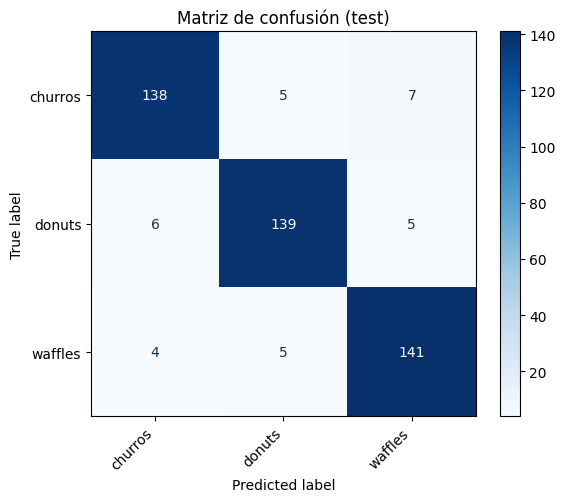

In [43]:
# Confusion matrix (absoluta)
cm = confusion_matrix(y_true, y_pred, labels=list(range(len(CLASS_NAMES))))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CLASS_NAMES)
fig, ax = plt.subplots(figsize=(6,5))
disp.plot(ax=ax, cmap="Blues", colorbar=True, values_format="d")
plt.xticks(rotation=45, ha="right"); plt.title("Matriz de confusión (test)")
plt.tight_layout(); plt.savefig("figures/confusion_matrix.png", dpi=200); plt.show()


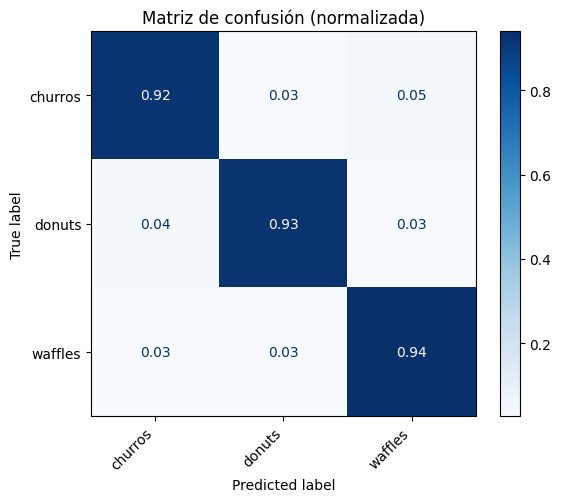

In [44]:
# Confusion matrix normalizada por fila
cm_norm = cm.astype("float") / (cm.sum(axis=1, keepdims=True) + 1e-9)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=CLASS_NAMES)
fig, ax = plt.subplots(figsize=(6,5))
disp.plot(ax=ax, cmap="Blues", colorbar=True, values_format=".2f")
plt.xticks(rotation=45, ha="right"); plt.title("Matriz de confusión (normalizada)")
plt.tight_layout(); plt.savefig("figures/confusion_matrix_normalized.png", dpi=200); plt.show()

In [46]:
report = classification_report(y_true, y_pred, target_names=CLASS_NAMES, digits=3)
print(report)
with open("figures/classification_report.txt","w") as f:
    f.write(report)

              precision    recall  f1-score   support

     churros      0.932     0.920     0.926       150
      donuts      0.933     0.927     0.930       150
     waffles      0.922     0.940     0.931       150

    accuracy                          0.929       450
   macro avg      0.929     0.929     0.929       450
weighted avg      0.929     0.929     0.929       450

